In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! python --version

Python 3.12.2


In [1]:
import numpy as np
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt
from NCP.model import NCPOperator, NCPModule
from NCP.nn.layers import MLP
from NCP.nn.losses import CMELoss, DDPMLoss
from NCP.metrics import hellinger, kullback_leibler, wasserstein1
from NCP.utils import frnp, FastTensorDataLoader
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

#import normflows as nf

# diffusion model imports:
from NCP.nn.diffusion_conditional import DDPM, ContextUnet
from NCP.nn.ddpm_module import DDPMModule

import itertools

from NCP.examples.tools.plot_utils import setup_plots
from NCP.examples.tools.data_gen import gen_bimodal, get_conditional_bimodal_cdf, get_conditional_bimodal_pdf
from NCP.examples.tools.lincde import lincde
setup_plots()

# TODO: add them to a utils folder
class CustomModelCheckpoint(ModelCheckpoint):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        X, Y = trainer.model.batch
        trainer.model.model._compute_data_statistics(X, Y)

def restore_buffers_shape(model, state_dict):
    model._sing_val = torch.zeros_like(state_dict['model._sing_val']).to('cpu')
    model._sing_vec_l = torch.zeros_like(state_dict['model._sing_vec_l']).to('cpu')
    model._sing_vec_r = torch.zeros_like(state_dict['model._sing_vec_r']).to('cpu')


np.random.seed(0)
torch.manual_seed(0)
Ntrain = 50000
Nval = 1000         # val dataset will be used to sample the marginal distribution of Y
Ntest = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#MODELS = ['lincde', 'NN', 'ddpm]
MODELS = ['NN', 'ddpm']

Generating bimodal data as presented in LinCDE (Gao and Hastie). X are 20 dimensional, but only the first 3 dimensions impact Y. 
- the first dimension gives the mean, 
- the second the modality (bi or uni modal) 
- the third the asymetry.

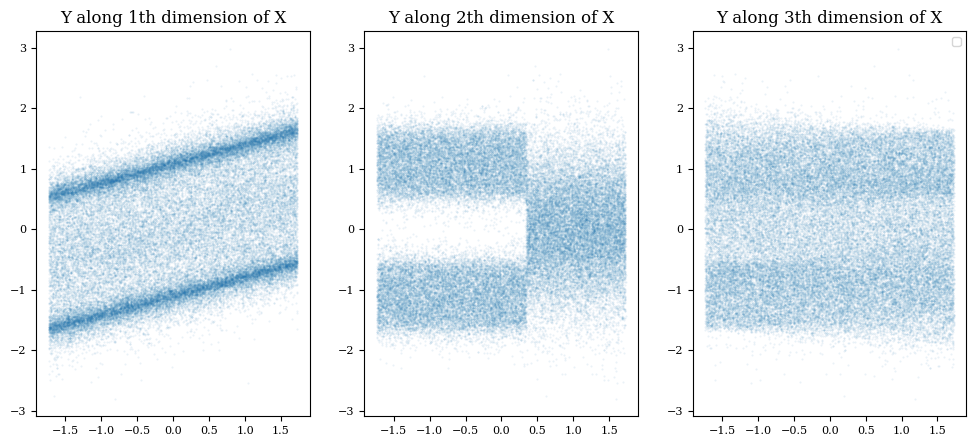

In [5]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, xscaler, yscaler = gen_bimodal(0.5, 30, N_train=Ntrain, N_val=Nval, N_test=Ntest)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
axes = ax.flatten()

for i, ax in enumerate(axes):
    ax.scatter(X_train[:,i], Y_train, alpha=0.1, s=0.2)
    ax.set_title(f'Y along {i+1}th dimension of X')
    if i == 0 :
        plt.legend(['train', 'val', 'test'])
plt.show()

# 1. training NCP

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9823: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s, v_num=8, val_loss=-1.35, train_loss=-1.37]   


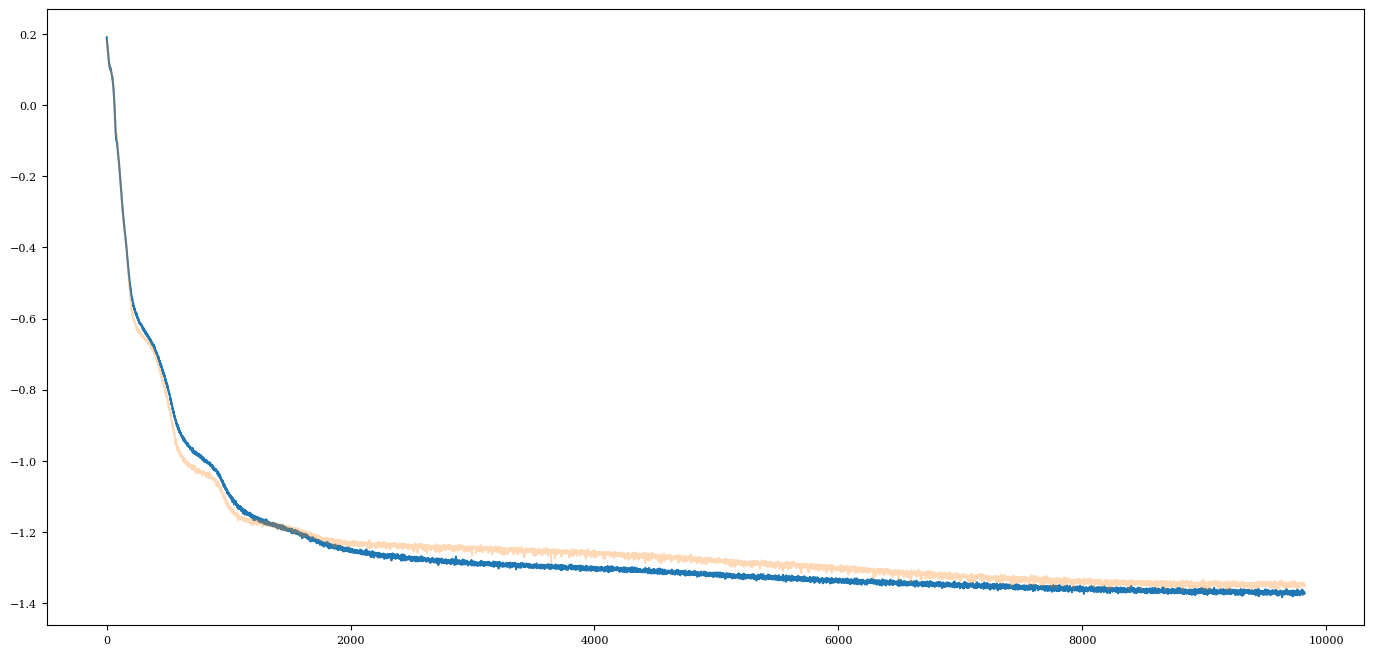

In [20]:
L.seed_everything(0)

lr = 1e-3
gamma = 1e-2
epochs = int(1e5)
output_shape = 10

MLP_kwargs_U = {
    'input_shape': X_train.shape[-1],
    'output_shape': output_shape,
    'n_hidden': 2,
    'layer_size': [32, 32],
    'dropout': 0.2,
    'iterative_whitening': False,
    'activation': torch.nn.Tanh
}

MLP_kwargs_V = {
    'input_shape': Y_train.shape[-1],
    'output_shape': output_shape,
    'n_hidden': 2,
    'layer_size': [16, 32],
    'dropout': 0,
    'iterative_whitening': False,
    'activation': torch.nn.Tanh
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs_U, V_operator_kwargs=MLP_kwargs_V)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

early_stop = EarlyStopping(monitor="val_loss", patience=1000, mode="min")
checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': True,
    'num_sanity_val_steps': 0,
    'enable_model_summary': False,
    }, callbacks=[early_stop, checkpoint_callback])

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

# recover best model during training
best_model_dict = torch.load(checkpoint_callback.best_model_path)
restore_buffers_shape(reg, best_model_dict['state_dict'])
NCP_module.load_state_dict(best_model_dict['state_dict'])
best_model = NCP_module.model

plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.show()

# 2. Training Normalising Flows

In [ ]:
# give the same capacity as the NCP network
density_estimator_kwargs = {'name': 'nflow', 'hidden_sizes': (32, 32), 'hidden_nonlinearity': tf.tanh}

model = NormalizingFlowEstimator(**density_estimator_kwargs)
model.fit(X_train, Y_train, eval_set=(X_val, Y_val), verbose=False)

# 3. Diffusion models

In [ ]:
# based on https://github.com/TeaPearce/Conditional_Diffusion_MNIST/blob/main/script.py

ddpm = DDPM(nn_model=ContextUnet(in_channels=1, x_dim=X_train.shape[-1], y_dim=Y_train.shape[-1]), betas=(1e-4, 0.02), n_T=400, device=device, drop_prob=0.1)

ddpm_module = DDPMModule(ddpm,
    optimizer,
    optimizer_kwargs,
    DDPMLoss,
    loss_kwargs)

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': True,
    'num_sanity_val_steps': 0,
    'enable_model_summary': False,
    }, callbacks=[early_stop, checkpoint_callback])

trainer.fit(ddpm_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

# 3. Training DDPM

In [ ]:
model = Unet1D(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels = 32
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = 128,
    timesteps = 1000,
    objective = 'pred_v'
)

training_seq = torch.rand(64, 32, 128) # features are normalized from 0 to 1

loss = diffusion(training_seq)
loss.backward()

# Or using trainer

dataset = Dataset1D(training_seq)  # this is just an example, but you can formulate your own Dataset and pass it into the `Trainer1D` below

trainer = Trainer1D(
    diffusion,
    dataset = dataset,
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = 700000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
)
trainer.train()


# 4. Results

result:
- KL: 0.8198916912078857
- Hellinger: 0.41064761892855633
result:
- KL: 0.8162281513214111
- Hellinger: 0.3834393415507121
result:
- KL: 1.3140294551849365
- Hellinger: 0.46435475793010944
result:
- KL: 1.4666746854782104
- Hellinger: 0.48148896913633427
result:
- KL: 0.7077239751815796
- Hellinger: 0.3627288859546409
result:
- KL: 1.0753109455108643
- Hellinger: 0.46838538749375175
result:
- KL: 0.5916972160339355
- Hellinger: 0.33619272436999986
result:
- KL: 0.5857585668563843
- Hellinger: 0.33527672583788837
result:
- KL: 0.5822353363037109
- Hellinger: 0.33436015832332194


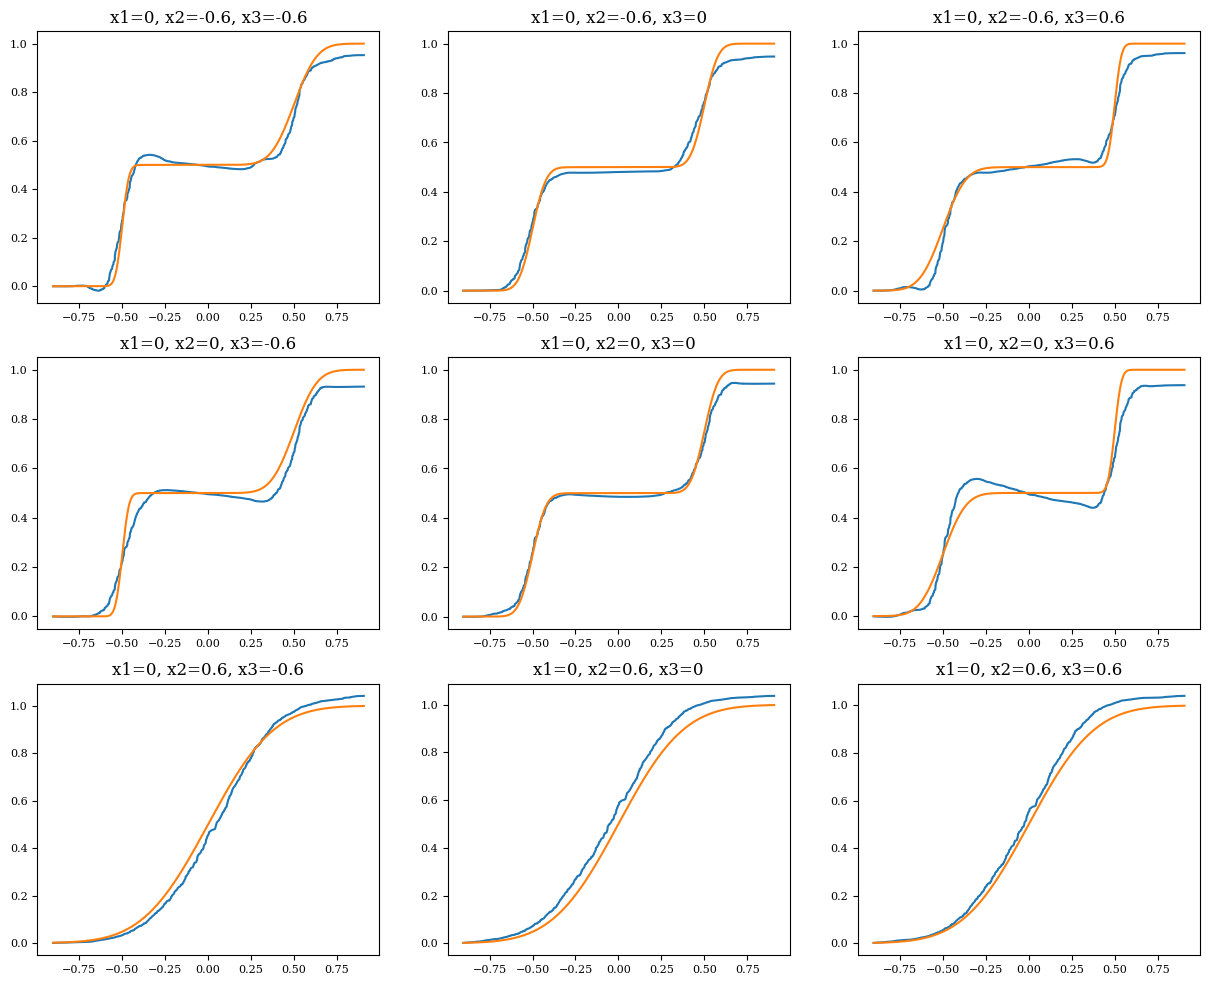

In [7]:
# todo: plot different cdfs, replicate plots from linCDE

x1 = [0] # mean
x3 = [-0.6, 0, 0.6] # asymetry
x2 = [-0.6, 0, 0.6] # modality

xs = itertools.product(x1, x2, x3)

fig, ax = plt.subplots(nrows=(len(x1)*len(x2)), ncols=len(x3), figsize=(15,12))
axes = ax.flatten()

for i, xi in enumerate(xs):
    x = list(xi) + [0]*17          # fill all other dimensions by 0
    x_scaled = torch.Tensor(xscaler.transform([x]))
    fys, cdf_pred = best_model.cdf(x_scaled, Y_val_torch, postprocess='whitening')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_cdf = get_conditional_bimodal_cdf(x, fys)

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x1={round(xi[0], 3)}, x2={round(xi[1], 3)}, x3={round(xi[2], 3)}')
    print('result:')
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf, fys)}')

plt.show()

Should we verify that the other dimensions are independent?

0.9934231
0.998807850849468
0.987066
1.0000126055430854
1.0000446
0.9987555676016466
0.98034805
0.998807850849468
0.9910942
1.0000126055430854
0.99715674
0.9987555676016466
0.99623406
0.9921211311240836
0.99149406
0.9921211311240836
0.9919811
0.9921211311240836


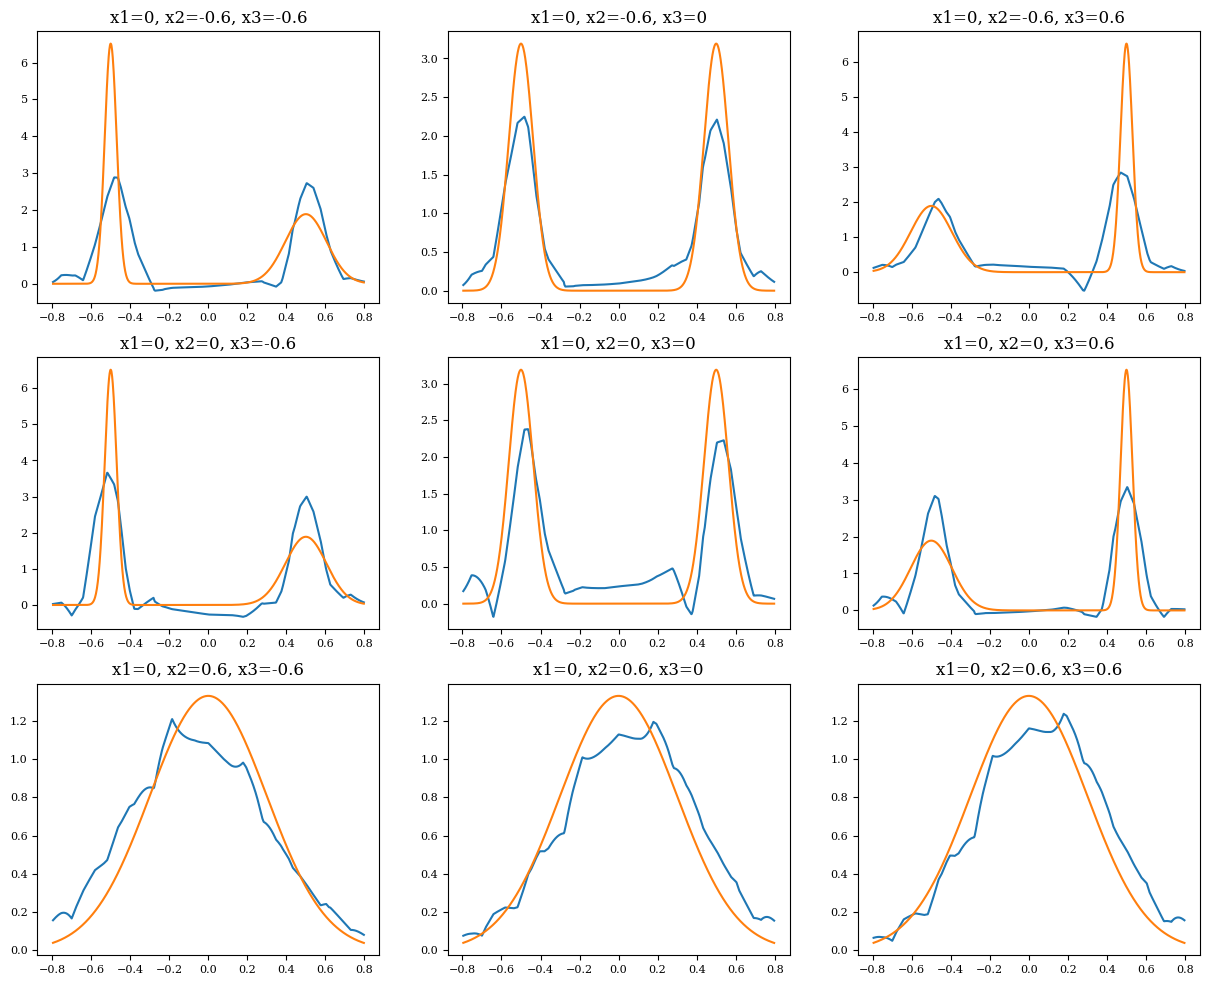

In [19]:
from sklearn.neighbors import KernelDensity
from NCP.cdf import compute_marginal

x1 = [0] # mean
x3 = [-0.6, 0, 0.6] # asymetry
x2 = [-0.6, 0, 0.6] # modality

xs = itertools.product(x1, x2, x3)

p1, p99 = np.percentile(Y_train, [1, 99])
y_discr, step = np.linspace(p1, p99, num=1000, retstep=True)
y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

fig, ax = plt.subplots(nrows=(len(x1)*len(x2)), ncols=len(x3), figsize=(15,12))
axes = ax.flatten()

k_pdf = compute_marginal(bandwidth='scott').fit(Y_train)
marginal = lambda x : torch.Tensor(np.exp(k_pdf.score_samples(x.reshape(-1, 1))))

for i, xi in enumerate(xs):
    x = list(xi) + [0]*17          # fill all other dimensions by 0
    x_scaled = xscaler.transform([x])
    x_scaled_torch = frnp(x_scaled)
    fys, pdf_pred = best_model.pdf(x_scaled_torch, y_discr_torch, p_y=marginal, postprocess='centering')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    pdf_pred /= yscaler.scale_

    true_pdf = get_conditional_bimodal_pdf(x, fys)

    axes[i].plot(fys, pdf_pred)
    axes[i].plot(fys, true_pdf)

    if 'lincde' in MODELS:
        y_lincde, lincde_pdf = cdf = lincde(X_train, Y_train, [x], y_discr)
        axes[i].plot(y_lincde, lincde_pdf)

    axes[i].set_title(f'x1={round(xi[0], 3)}, x2={round(xi[1], 3)}, x3={round(xi[2], 3)}')

plt.show()

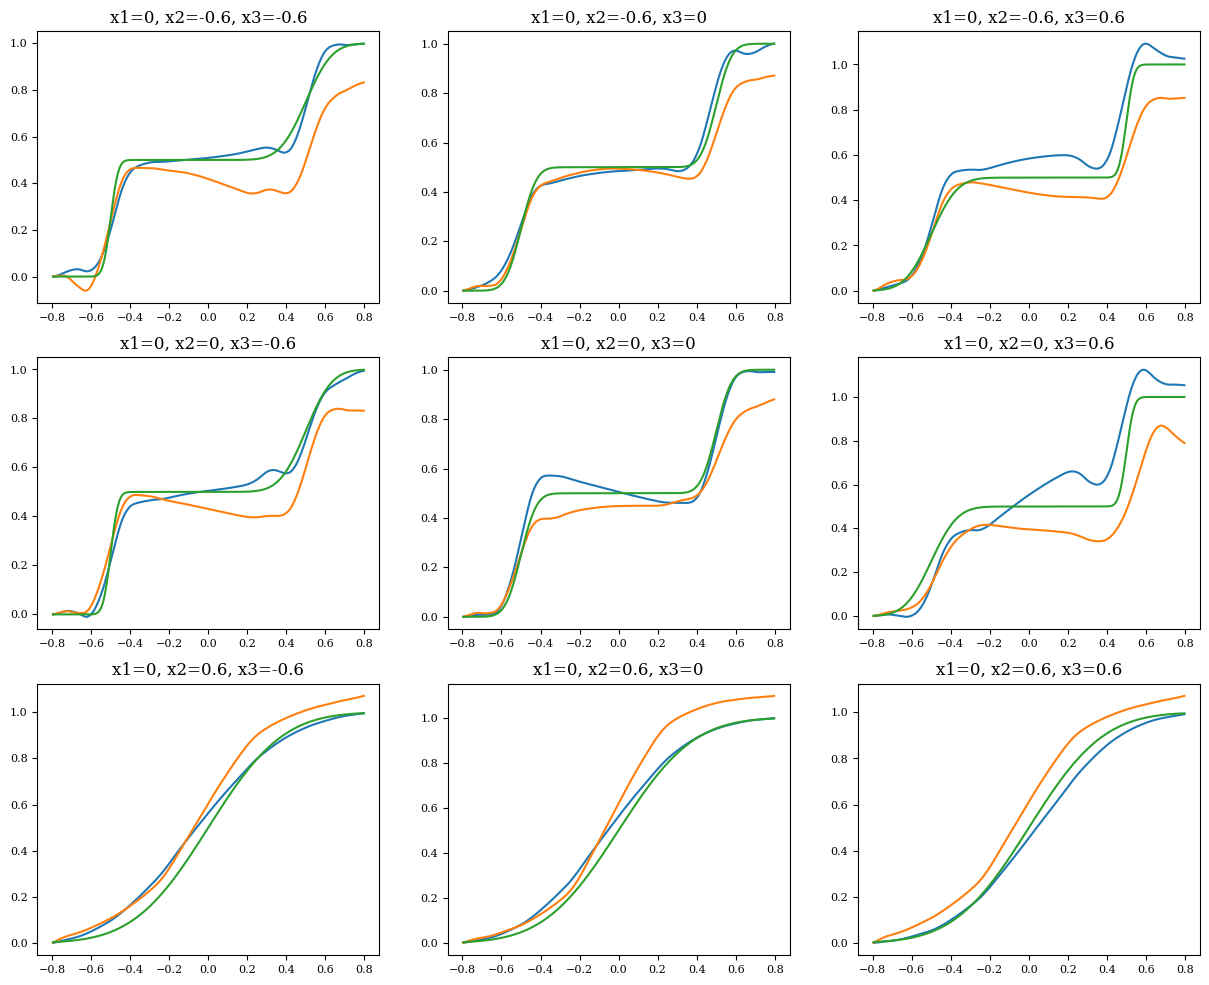

In [11]:
x1 = [0] # mean
x3 = [-0.6, 0, 0.6] # asymetry
x2 = [-0.6, 0, 0.6] # modality

xs = itertools.product(x1, x2, x3)

p1, p99 = np.percentile(Y_train, [1, 99])
y_discr, step = np.linspace(p1, p99, num=1000, retstep=True)
y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

fig, ax = plt.subplots(nrows=(len(x1)*len(x2)), ncols=len(x3), figsize=(15,12))
axes = ax.flatten()

k_pdf = compute_marginal(bandwidth='scott').fit(Y_train)
marginal = lambda x : torch.Tensor(np.exp(k_pdf.score_samples(x.reshape(-1, 1))))

for i, xi in enumerate(xs):
    x = list(xi) + [0]*17          # fill all other dimensions by 0
    x_scaled = xscaler.transform([x])
    x_scaled_torch = frnp(x_scaled)
    fys, pdf_pred = best_model.pdf(x_scaled_torch, y_discr_torch, p_y=marginal, postprocess='centering')
    fys, cdf_pred = best_model.cdf(x_scaled_torch, y_discr_torch, postprocess='centering')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_pdf = get_conditional_bimodal_cdf(x, fys)

    axes[i].plot(fys, np.cumsum(pdf_pred*step))
    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_pdf)

    if 'lincde' in MODELS:
        y_lincde, lincde_pdf = cdf = lincde(X_train, Y_train, [x], y_discr)
        axes[i].plot(y_lincde, lincde_pdf)

    axes[i].set_title(f'x1={round(xi[0], 3)}, x2={round(xi[1], 3)}, x3={round(xi[2], 3)}')

plt.show()